# Predict regulatory regions from the DNA sequence using HDF5 datasets

In this notebook we illustrate several variants how to predict regulatory regions (of a toy example) from the DNA sequence.
The reference genome is made up of a concatenation of Oct4 and Mafk binding sites and we shall use all regions on chromosome 'pseudo1' as training
and 'pseudo2' as test chromosomes.

In [1]:
import os

import numpy as np
from keras import Model
from keras import backend as K
from keras.layers import Conv2D

from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Reshape

from pkg_resources import resource_filename

from janggu import Janggu
from janggu import Scorer
from janggu import inputlayer
from janggu import outputdense
from janggu.data import Bioseq
from janggu.data import Cover
from janggu.data import ReduceDim
from janggu.layers import DnaConv2D
from janggu.layers import LocalAveragePooling2D
from janggu.utils import ExportClustermap
from janggu.utils import ExportTsne
from janggu.utils import ExportTsv

from IPython.display import Image

np.random.seed(1234)

/home/wkopp/anaconda3/envs/jdev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First, we need to specify the output directory in which the results are stored.

In [2]:
os.environ['JANGGU_OUTPUT'] = '/home/wkopp/janggu_examples'

Specify the DNA sequence feature order. Order 1, 2 and 3 correspond to mono-, di- and tri-nucleotide based features (see Tutorial).

In [3]:
order = 3

In [4]:
# load the dataset
# The pseudo genome represents just a concatenation of all sequences
# in sample.fa and sample2.fa. Therefore, the results should be almost
# identically to the models obtained from classify_fasta.py.
REFGENOME = resource_filename('janggu', 'resources/pseudo_genome.fa')
# ROI contains regions spanning positive and negative examples
ROI_TRAIN_FILE = resource_filename('janggu', 'resources/roi_train.bed')
ROI_TEST_FILE = resource_filename('janggu', 'resources/roi_test.bed')
# PEAK_FILE only contains positive examples
PEAK_FILE = resource_filename('janggu', 'resources/scores.bed')

Using data directly from HDF5 can be tricky.
For example, it might be prohibitively slow to use data 
from HDF5 with in conjunction with randomization option in the model.fit method, because of limitations of the HDF5 file format.
HDF5 data may be read more efficiently in coherent blocks.

To overcome this limitation, it is possible to randomize the dataset already at loading time.
That way randomization may be avoided in the model.fit method such that coherent yet randomized batches are consumed
during training.

For the randomization to be effective, use store_whole_genome=False and use the same random_state for all training dataset objects to make sure that the intervals are aligned.

In [5]:
# Training input and labels are purely defined genomic coordinates
# applying a random state internally randomizes the dataset
# in this case, shuffling of the mini-batches during training
# becomes obsolete.
# Importantly, the same state needs to be used for all datasets
# to enforce synchronized datasets.
DNA = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                   roi=ROI_TRAIN_FILE,
                                   binsize=200,
                                   order=order,
                                   storage='hdf5',
                                   cache=True,
                                   store_whole_genome=False,
                                   random_state=43)

LABELS = ReduceDim(Cover.create_from_bed('peaks', roi=ROI_TRAIN_FILE,
                               bedfiles=PEAK_FILE,
                               binsize=200,
                               resolution=200,
                               storage='sparse',
                               cache=True,
                               store_whole_genome=True,
                               random_state=43))

loading from lazy loader
reload /home/wkopp/janggu_examples/datasets/dna/347df68279d48736dbac1cb3475dbdec75833b9c6b098a1c33e9a6bd757f5cbe.h5
reload /home/wkopp/janggu_examples/datasets/peaks/15ff635afa19facb6b20276568b4447ceb85e0205ac7a6661f710141d7aa1d7f.npz


For the test sets, randomization is not required, so we just don't specify the random_state.

In [6]:
DNA_TEST = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                        roi=ROI_TEST_FILE,
                                        binsize=200,
                                        storage='hdf5',
                                        cache=True,
                                        order=order)

LABELS_TEST = ReduceDim(Cover.create_from_bed('peaks',
                                    bedfiles=PEAK_FILE,
                                    roi=ROI_TEST_FILE,
                                    binsize=200,
                                    storage='hdf5',
                                    cache=True,
                                    resolution=200))


loading from lazy loader
reload /home/wkopp/janggu_examples/datasets/dna/39fa662199640ed381bf7c4a2730b96aae0722c78836a790eaea231d88fed8c0.h5
loading from bed lazy loader
reload /home/wkopp/janggu_examples/datasets/peaks/a29de032bb3a21ad582a3aaa865f3ce1f6d58ebfcee455351ed4ea422e5166ea.h5


## Define and fit a conv net

As in the other examples,
we define the neural network using the Janggu model wrapper functionality.


In [7]:
@inputlayer
@outputdense('sigmoid')
def double_stranded_model_dnaconv(inputs, inp, oup, params):
    """ keras model for scanning both DNA strands.

    A more elegant way of scanning both strands for motif occurrences
    is achieved by the DnaConv2D layer wrapper, which internally
    performs the convolution operation with the normal kernel weights
    and the reverse complemented weights.
    """
    with inputs.use('dna') as layer:
        # the name in inputs.use() should be the same as the dataset name.
        layer = DnaConv2D(Conv2D(params[0], (params[1], 1),
                                 activation=params[2]))(layer)
    output = GlobalAveragePooling2D(name='motif')(layer)
    return inputs, output


Now the model can be instantiated accordingly. We will also use a specific model name (which is optional).

In [8]:
modelname = 'dna2peak_ex3_order{}'.format(order)

In [9]:
modelname

'dna2peak_ex3_order3'

Important: Now you use shuffle=False for the model fit method, since the dataset objects have already been randomized. This way, mini-batches can be read from the HDF5 file in coherent blocks.

In [10]:
# create a new model object
model = Janggu.create(template=double_stranded_model_dnaconv,
                      modelparams=(30, 21, 'relu'),
                      inputs=DNA,
                      outputs=LABELS,
                      name=modelname)

model.compile(optimizer='adadelta', loss='binary_crossentropy',
              metrics=['acc'])

hist = model.fit(DNA, LABELS, epochs=100, shuffle=False)

print('#' * 40)
print('loss: {}, acc: {}'.format(hist.history['loss'][-1],
                                 hist.history['acc'][-1]))
print('#' * 40)




Epoch 1/100
244/244 [==============================] - 5s 18ms/step - loss: 0.5663 - acc: 0.7448
Epoch 2/100
244/244 [==============================] - 4s 15ms/step - loss: 0.4670 - acc: 0.7965
Epoch 3/100
244/244 [==============================] - 3s 14ms/step - loss: 0.4216 - acc: 0.8181
Epoch 4/100
244/244 [==============================] - 3s 14ms/step - loss: 0.3911 - acc: 0.8339
Epoch 5/100
244/244 [==============================] - 4s 16ms/step - loss: 0.3661 - acc: 0.8473
Epoch 6/100
244/244 [==============================] - 4s 18ms/step - loss: 0.3432 - acc: 0.8578
Epoch 7/100
244/244 [==============================] - 4s 18ms/step - loss: 0.3215 - acc: 0.8726
Epoch 8/100
244/244 [==============================] - 4s 18ms/step - loss: 0.3008 - acc: 0.8827
Epoch 9/100
244/244 [==============================] - 4s 17ms/step - loss: 0.2811 - acc: 0.8928
Epoch 10/100
244/244 [==============================] - 4s 15ms/step - loss: 0.2625 - acc: 0.9012
Epoch 11/100
244/244 [=======

244/244 [==============================] - 4s 16ms/step - loss: 0.0188 - acc: 0.9986
Epoch 85/100
244/244 [==============================] - 3s 14ms/step - loss: 0.0183 - acc: 0.9987
Epoch 86/100
244/244 [==============================] - 3s 13ms/step - loss: 0.0179 - acc: 0.9990
Epoch 87/100
244/244 [==============================] - 3s 13ms/step - loss: 0.0174 - acc: 0.9991
Epoch 88/100
244/244 [==============================] - 3s 13ms/step - loss: 0.0170 - acc: 0.9991
Epoch 89/100
244/244 [==============================] - 3s 14ms/step - loss: 0.0165 - acc: 0.9991
Epoch 90/100
244/244 [==============================] - 4s 15ms/step - loss: 0.0161 - acc: 0.9991
Epoch 91/100
244/244 [==============================] - 3s 14ms/step - loss: 0.0157 - acc: 0.9991
Epoch 92/100
244/244 [==============================] - 3s 14ms/step - loss: 0.0153 - acc: 0.9991
Epoch 93/100
244/244 [==============================] - 4s 15ms/step - loss: 0.0149 - acc: 0.9992
Epoch 94/100
244/244 [===========

[0.10043038666248322, 0.955]

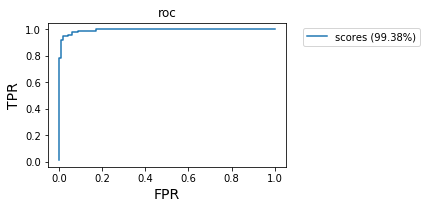

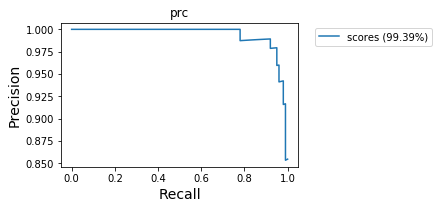

In [11]:
# do the evaluation on the independent test data
model.evaluate(DNA_TEST, LABELS_TEST, datatags=['test'],
               callbacks=['auc', 'auprc', 'roc', 'prc'])

In [12]:
evaluation_folder = os.path.join(os.environ['JANGGU_OUTPUT'], 'evaluation', modelname, 'test')

In [13]:
print(evaluation_folder)

/home/wkopp/janggu_examples/evaluation/dna2peak_ex3_order3/test


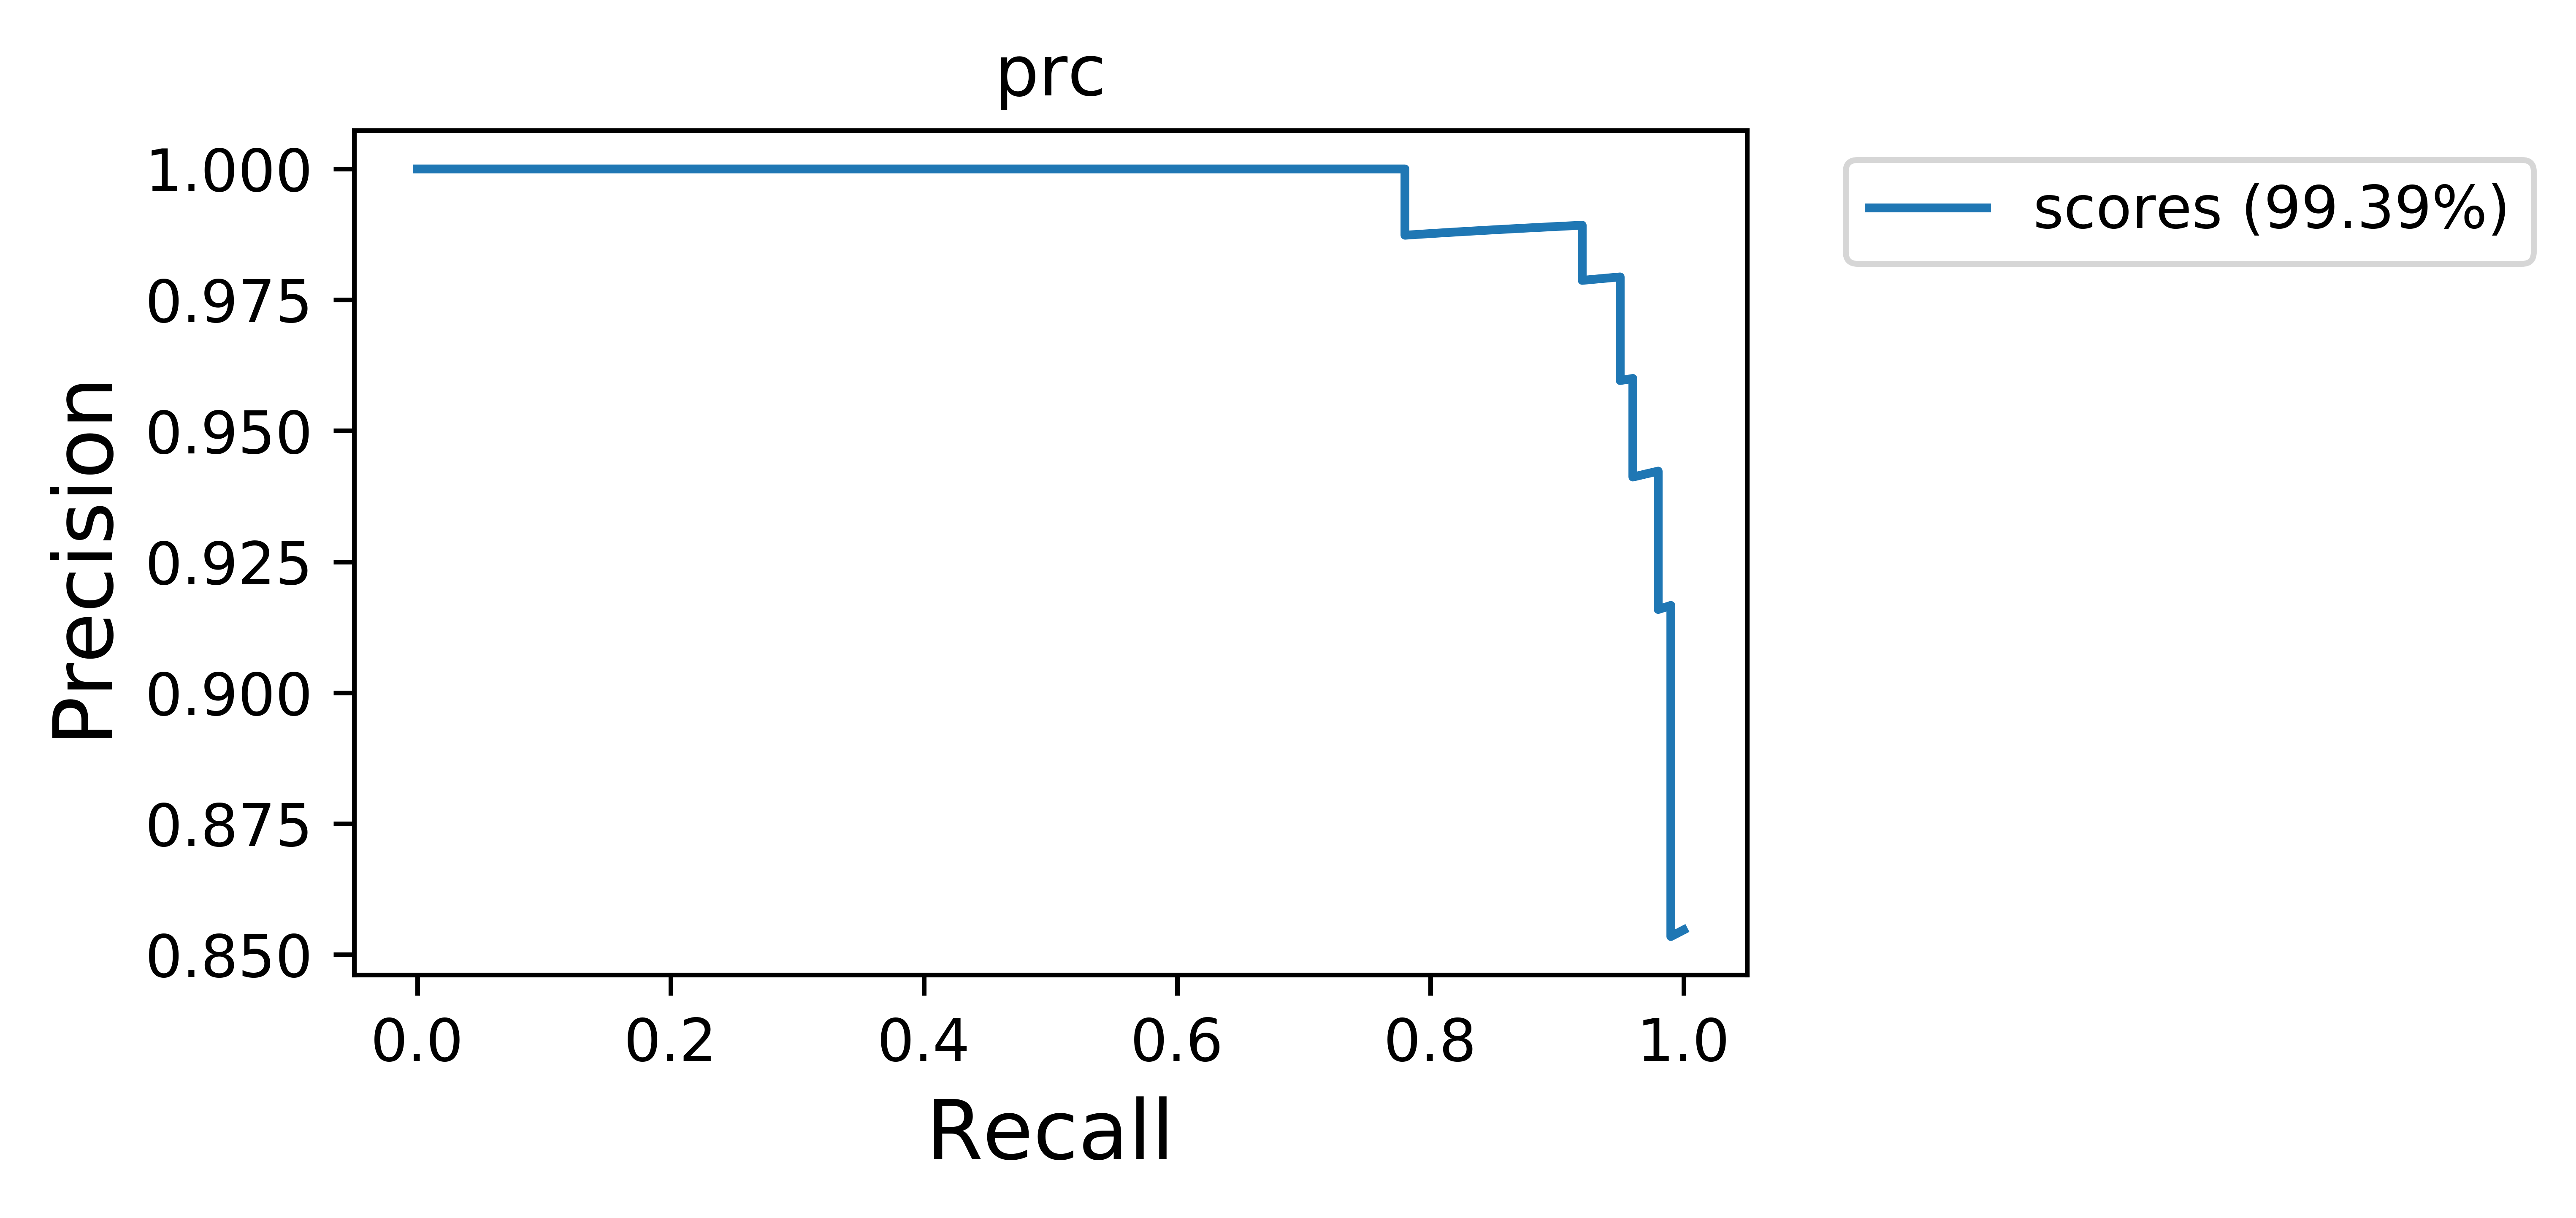

In [14]:
Image(os.path.join(evaluation_folder, 'prc.png'))

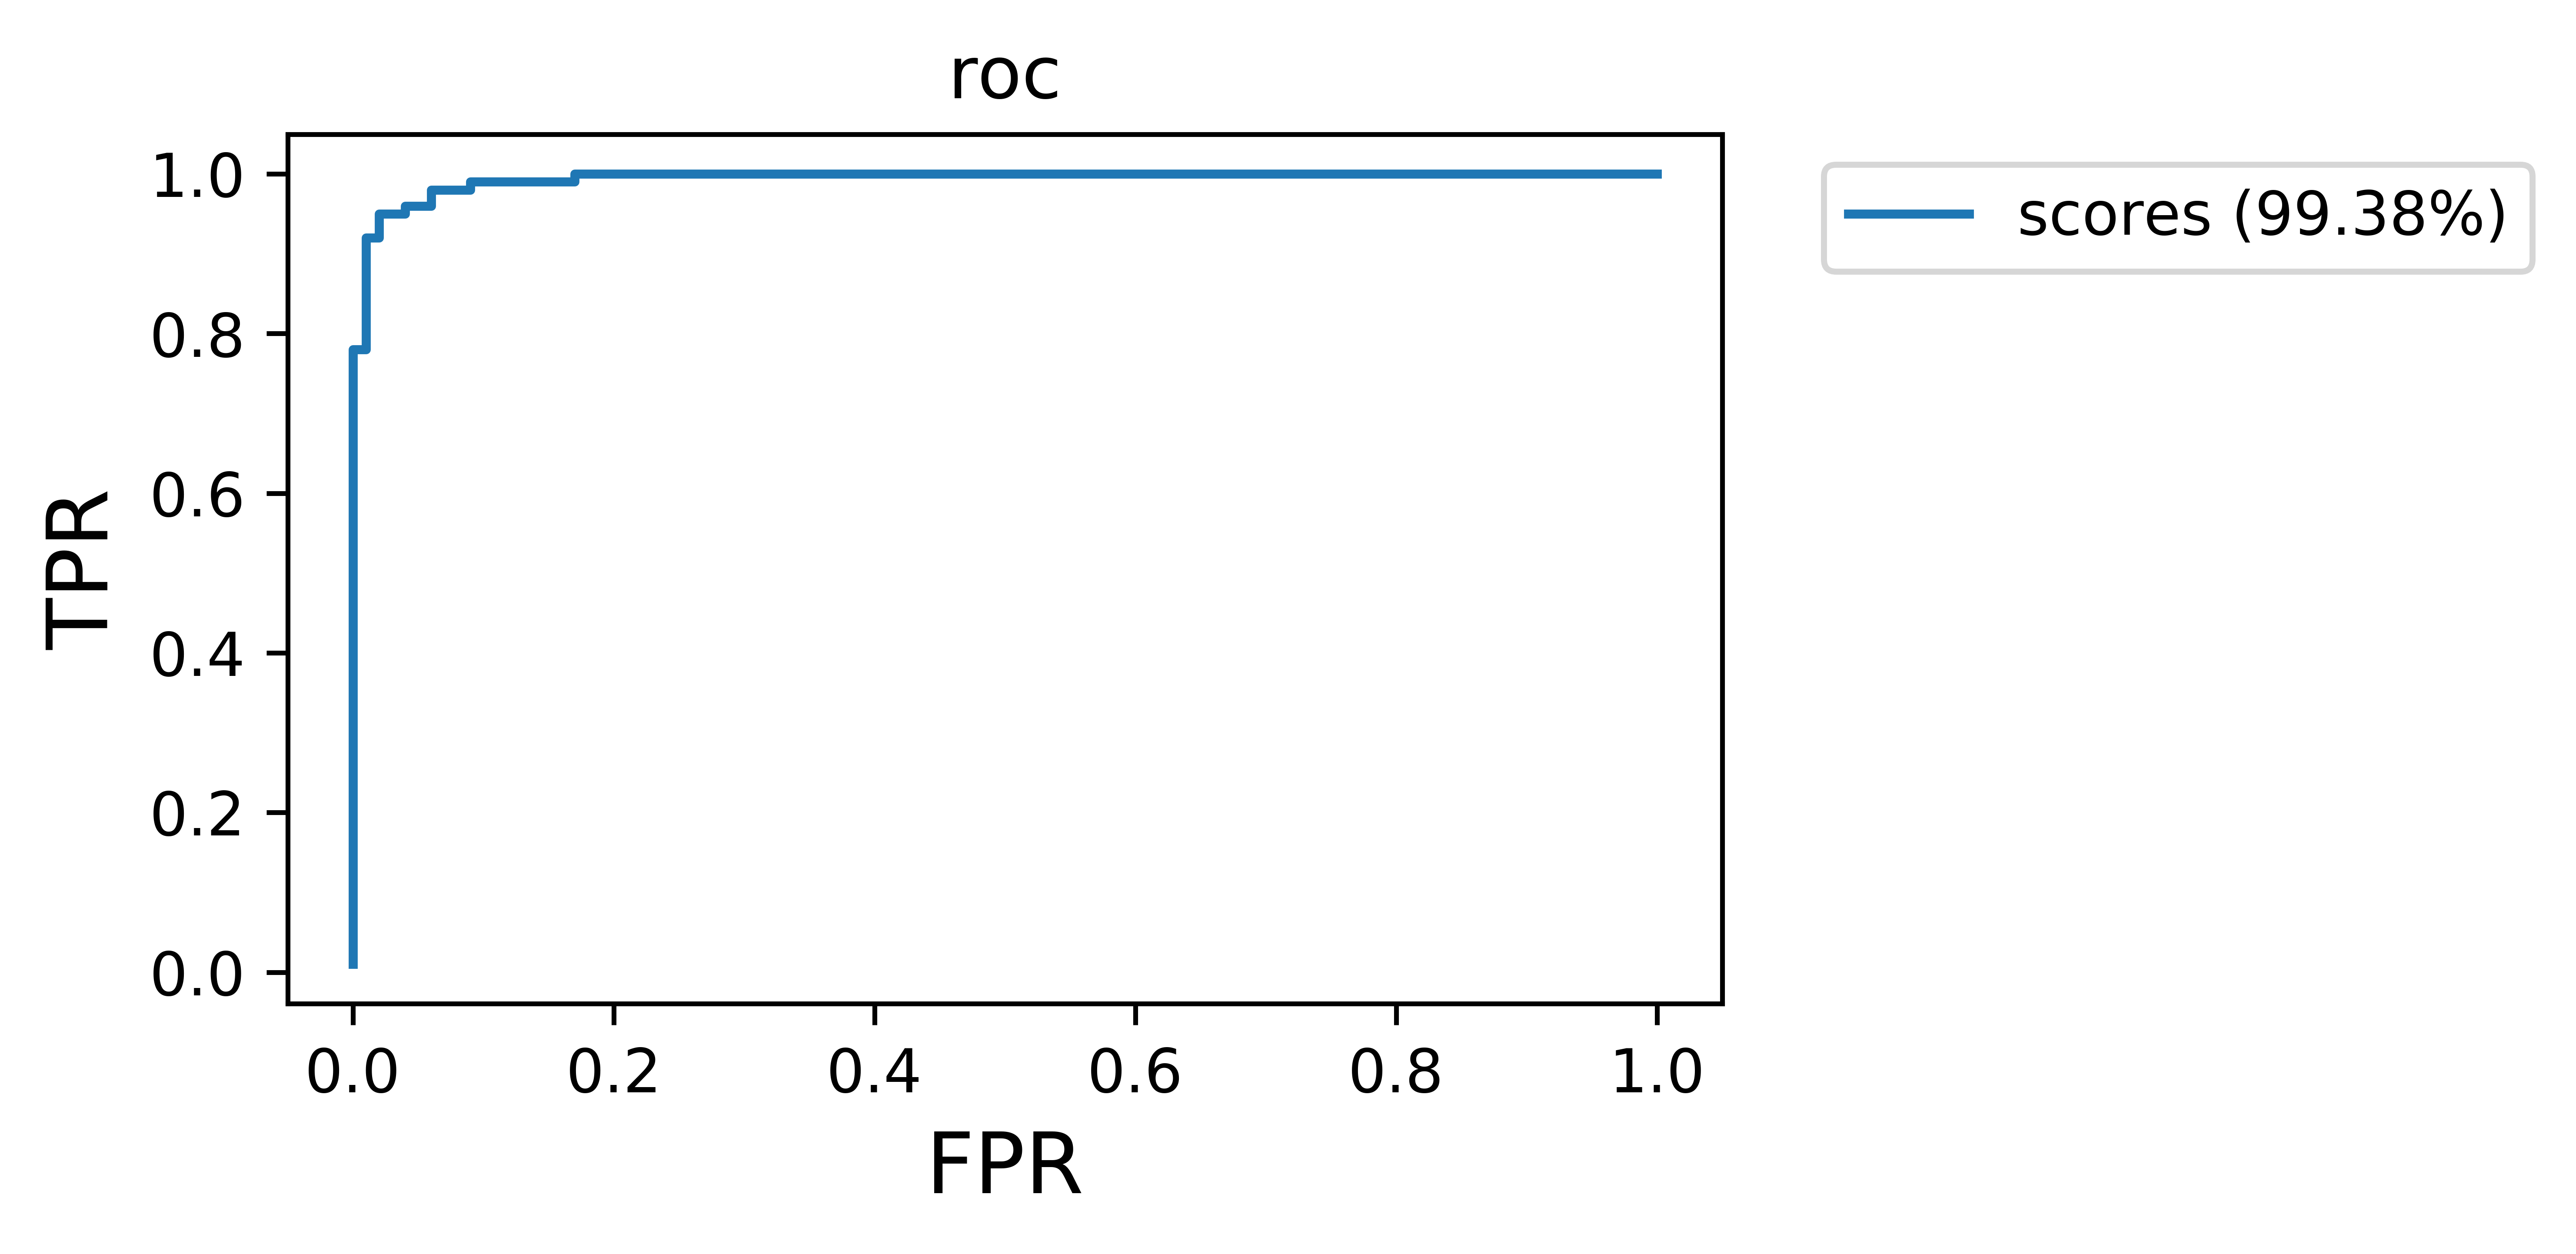

In [15]:
Image(os.path.join(evaluation_folder, 'roc.png'))